In [5]:
#primero importamos los paquetes necesarios
import os
import skimage
import numpy as np
import cv2
import matplotlib
import pyinpaint

from skimage import io
from matplotlib import pyplot as plt
from skimage import color
from pyinpaint import Inpaint
from skimage.restoration import inpaint

## DESARROLLO DE CÓDIGO PARA DETECTAR EL FLASH MEDIANTE IDENTIFICACIÓN DE CÍRCULOS

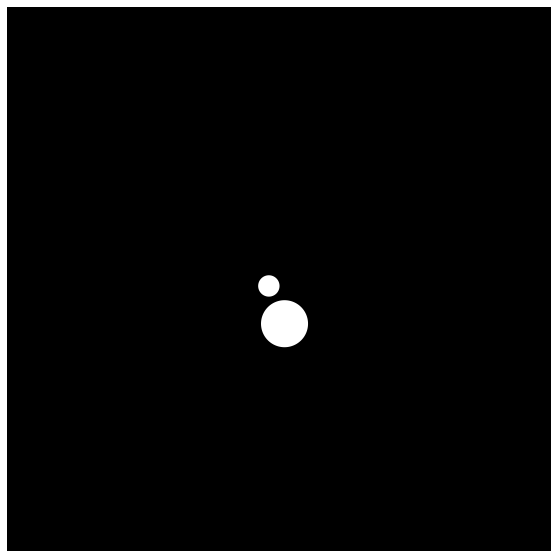

In [2]:
img = io.imread('Classified Data/Images/iPhone/G3/489959EI.png')
  
# Convert to grayscale.
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
# Blur using 3 * 3 kernel.
gray_blurred = cv2.blur(gray, (3, 3))
  
# Apply Hough transform on the blurred image.
detected_circles = cv2.HoughCircles(
    gray_blurred,
    cv2.HOUGH_GRADIENT,
    2.2,
    20,
    param1 = 50,
    param2 = 30,
    minRadius = 1,
    maxRadius = int(img.shape[0]/53)
)

mask = np.zeros((img.shape[0], img.shape[1]), dtype = 'uint8')

if detected_circles is not None:
    detected_circles = np.uint16(np.around(detected_circles))
        
    nuevos = []
    for i in detected_circles[0]:
        if 11*(img.shape[1]/30)<i[1]<18*(img.shape[1]/30) and 13*(img.shape[0]/30)<i[0]<17*(img.shape[0]/30):
            nuevos.append(i)

    s = np.linspace(0, 2*np.pi, 400)
    fig = plt.figure(figsize = (10,10))
    plt.imshow(mask, cmap = 'gray')
    plt.axis('off')

    #lo multiplico por 3 para tratar de hacer la máscara más grande y ver si así obtengo mejores resultados
    #si queremos obtener una mácara real, se puede eliminar ese factor 1.75
    for i in nuevos:
        comp_x = i[0] + (3*i[2])*np.cos(s)
        comp_y = i[1] + (3*i[2])*np.sin(s)
        circle = np.array([comp_y, comp_x]).T
        
        plt.fill(circle[:,1], circle[:,0],'white',1)

In [3]:
fig.tight_layout(pad=0)
fig.canvas.draw()

# Now we can save it to a numpy array.
data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

mascara = cv2.resize(data, dsize=(img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
mascara = color.rgb2gray(mascara).astype('uint8')

## INPAINTING USANDO ESTAS MÁSCARAS

In [4]:
img_inp = inpaint.inpaint_biharmonic(img, mascara, multichannel = True, channel_axis=-1)

C:\Users\samue\AppData\Local\Temp\ipykernel_12660\1106700315.py:1: FutureWarning: `multichannel` is a deprecated argument name for `inpaint_biharmonic`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img_inp = inpaint.inpaint_biharmonic(img, mascara, multichannel = True, channel_axis=-1)


## INPAINTING DE IMÁGENES ALEATORIAS PARA LA EVALUACIÓN

In [5]:
def inpaint(nombre, dispositivo, grado):
    source = 'Classified Data/Images/' + dispositivo + '/' + grado + '/' + nombre
    img = io.imread(source)
  
    # Convert to grayscale.
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Blur using 3 * 3 kernel.
    gray_blurred = cv2.blur(gray, (3, 3))

    # Apply Hough transform on the blurred image.
    detected_circles = cv2.HoughCircles(
        gray_blurred,
        cv2.HOUGH_GRADIENT,
        2.2,
        20,
        param1 = 50,
        param2 = 30,
        minRadius = 1,
        maxRadius = int(img.shape[0]/53)
    )

    mask = np.zeros((img.shape[0], img.shape[1]), dtype = 'uint8')

    if detected_circles is not None:
        detected_circles = np.uint16(np.around(detected_circles))

        nuevos = []
        for i in detected_circles[0]:
            if 11*(img.shape[1]/30)<i[1]<18*(img.shape[1]/30) and 13*(img.shape[0]/30)<i[0]<17*(img.shape[0]/30):
                nuevos.append(i)

        s = np.linspace(0, 2*np.pi, 400)
        fig = plt.figure(figsize = (10,10))
        plt.imshow(mask, cmap = 'gray')
        plt.axis('off')

        #lo multiplico por 3 para tratar de hacer la máscara más grande y así obtener mejores resultados del inpainting
        #si queremos obtener una mácara real, se puede eliminar ese factor 3
        for i in nuevos:
            comp_x = i[0] + (3*i[2])*np.cos(s)
            comp_y = i[1] + (3*i[2])*np.sin(s)
            circle = np.array([comp_y, comp_x]).T

            plt.fill(circle[:,1], circle[:,0],'white',1)
            
    
    fig.tight_layout(pad=0)
    fig.canvas.draw()

    # Now we can save it to a numpy array.
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    mascara = cv2.resize(data, dsize=(img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
    mascara = color.rgb2gray(mascara).astype('uint8')
    
    img_inp = inpaint.inpaint_biharmonic(img, mascara, multichannel = True, channel_axis=-1)

    fig = plt.figure(figsize = (20,20))

    fig.add_subplot(1,2,1)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Imagen original")

    fig.add_subplot(1,2,2)
    plt.imshow(img_inp)
    plt.axis('off')
    plt.title("Imagen con inpainting")
    
    ruta2 = 'INP_auto/' + dispositivo + '/' + grado + '/' + nombre + '_comparacion.png'
    plt.savefig(ruta2, bbox_inches = 'tight', pad_inches = 0) 